In [360]:
# import dependencies
from path import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.svm import SVR,SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta,datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# imports for database connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func

# import these to view table column headers & rows
from sqlalchemy.orm import sessionmaker
from sqlalchemy import select

import time

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = None

In [361]:
engine = create_engine("sqlite:///../Resources/covid_db.db")

In [362]:
# reflect an existing database into a new model (creates base class for automap schema)
Base = automap_base()

In [363]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [364]:
Base.classes.keys()

['covid_stats', 'government_regulation']

In [365]:
# save references to each table
covid_stats = Base.classes.covid_stats
government_regulation = Base.classes.government_regulation

In [366]:
# Create session (link) from Python to the database
session = sessionmaker(bind=engine)()

In [367]:
# View table column headers & rows - covid_stats
covid_stats_table = select('*').select_from(covid_stats)
covid_stats_result = session.execute(covid_stats_table).fetchall()
# print(covid_stats.__table__.columns.keys())
# print(covid_stats_result)

In [368]:
# View table column headers & rows - government_regulation
government_regulation_table = select('*').select_from(government_regulation)
government_regulation_result = session.execute(government_regulation_table).fetchall()
# print(government_regulation.__table__.columns.keys())
# print(government_regulation_result)

In [369]:
# Merge covid_stats_table with government regulation_table
joined = session.query(covid_stats.primary_key_reaction,\
                        covid_stats.date_updated,\
                        covid_stats.iso_code,\
                        covid_stats.continent,\
                        covid_stats.location,\
                        covid_stats.population,\
                        covid_stats.population_density,\
                        covid_stats.median_age,\
                        covid_stats.new_cases,\
                        covid_stats.percentage_of_Pop_New_Cases,\
                        covid_stats.new_deaths,\
                        covid_stats.percentage_of_Pop_New_Deaths,\
                        covid_stats.new_tests,\
                        covid_stats.percentage_of_Pop_New_Tests,\
                        covid_stats.total_cases_updated,\
                        covid_stats.percentage_of_Pop_Total_Cases,\
                        covid_stats.total_deaths_updated,\
                        covid_stats.percentage_of_Pop_Total_Deaths,\
                        covid_stats.total_tests_updated,\
                        covid_stats.percentage_of_Pop_Total_Tests,\
                       government_regulation.primary_key_response,\
                       government_regulation.StringencyIndex_updated,\
                       government_regulation.percentage_change_stringency,\
                       government_regulation.StringencyLegacyIndex_updated,\
                       government_regulation.GovernmentResponseIndex_updated,\
                       government_regulation.percentage_change_GovernmentResponse,\
                       government_regulation.ContainmentHealthIndex_updated,\
                       government_regulation.percentage_change_ContainmentHealth,\
                       government_regulation.EconomicSupportIndex_updated,\
                       government_regulation.percentage_change_EconomicSupport)\
        .join(government_regulation,government_regulation.primary_key_response == covid_stats.primary_key_reaction)

# save the query results as a Pandas DataFrame and set the index
df = pd.DataFrame(joined, columns=['primary_key_reaction',
                                             'date_updated',
                                             'iso_code',
                                             'continent',
                                             'location',
                                             'population',
                                             'population_density',
                                             'median_age',
                                             'new_cases',
                                             'percentage_of_Pop_New_Cases',
                                             'new_deaths',
                                             'percentage_of_Pop_New_Deaths',
                                             'new_tests',
                                             'percentage_of_Pop_New_Tests',
                                             'total_cases_updated',
                                             'percentage_of_Pop_Total_Cases',
                                             'total_deaths_updated',
                                             'percentage_of_Pop_Total_Deaths',
                                             'total_tests_updated',
                                             'percentage_of_Pop_Total_Tests',
                                             'primary_key_response',
                                             'StringencyIndex_updated',
                                             'percentage_change_stringency',
                                             'StringencyLegacyIndex_updated',
                                             'GovernmentResponseIndex_updated',
                                             'percentage_change_GovernmentResponse',
                                             'ContainmentHealthIndex_updated',
                                             'percentage_change_ContainmentHealth',
                                             'EconomicSupportIndex_updated',
                                             'percentage_change_EconomicSupport'
                                             ])

In [370]:
# preview 
df

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,total_cases_updated,percentage_of_Pop_Total_Cases,total_deaths_updated,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport
0,ABW2020-03-13,2020-03-13,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,2,0.001873,0,0.000000,0,0.000000,ABW2020-03-13,0.00,0.000000,0.00,2.56,0.000000,3.03,0.000000,0.0,0.0
1,ABW2020-03-19,2020-03-19,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,2,0.001873,0,0.000000,0,0.000000,ABW2020-03-19,33.33,0.000000,42.86,29.49,15.015601,34.85,15.016502,0.0,0.0
2,ABW2020-03-20,2020-03-20,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-20,33.33,0.000000,42.86,29.49,0.000000,34.85,0.000000,0.0,0.0
3,ABW2020-03-21,2020-03-21,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-21,44.44,33.333333,60.71,37.18,26.076636,43.94,26.083214,0.0,0.0
4,ABW2020-03-22,2020-03-22,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,4,0.003747,0,0.000000,0,0.000000,ABW2020-03-22,44.44,0.000000,60.71,37.18,0.000000,43.94,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32272,ZWE2020-08-27,2020-08-27,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,55,0.000370,13,8.746595e-07,951,0.006398,6251,0.042058,179,0.001204,95721,0.644025,ZWE2020-08-27,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32273,ZWE2020-08-28,2020-08-28,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,41,0.000276,10,6.728150e-07,1551,0.010435,6292,0.042334,189,0.001272,97272,0.654461,ZWE2020-08-28,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32274,ZWE2020-08-29,2020-08-29,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,96,0.000646,6,4.036890e-07,0,0.000000,6388,0.042979,195,0.001312,97272,0.654461,ZWE2020-08-29,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0
32275,ZWE2020-08-30,2020-08-30,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,18,0.000121,1,6.728150e-08,0,0.000000,6406,0.043101,196,0.001319,97272,0.654461,ZWE2020-08-30,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0


In [371]:
df.columns

Index(['primary_key_reaction', 'date_updated', 'iso_code', 'continent',
       'location', 'population', 'population_density', 'median_age',
       'new_cases', 'percentage_of_Pop_New_Cases', 'new_deaths',
       'percentage_of_Pop_New_Deaths', 'new_tests',
       'percentage_of_Pop_New_Tests', 'total_cases_updated',
       'percentage_of_Pop_Total_Cases', 'total_deaths_updated',
       'percentage_of_Pop_Total_Deaths', 'total_tests_updated',
       'percentage_of_Pop_Total_Tests', 'primary_key_response',
       'StringencyIndex_updated', 'percentage_change_stringency',
       'StringencyLegacyIndex_updated', 'GovernmentResponseIndex_updated',
       'percentage_change_GovernmentResponse',
       'ContainmentHealthIndex_updated', 'percentage_change_ContainmentHealth',
       'EconomicSupportIndex_updated', 'percentage_change_EconomicSupport'],
      dtype='object')

In [372]:
# Split up the dataframe by country then apply the future cases and deaths to each individual dataframe

def split(df,col):
#     print(df)
#     print(col)
    uvals = df[col].unique()
    
    dfs = []
    
    for val in uvals:
        dfs.append(df[df[col]==val].copy())
        
    
    return dfs

In [373]:
iso_codes = df["iso_code"].unique()
future = ["30", "45", "60", "75"]

iso_dicts = {}
for code in iso_codes:
    
    iso_dicts[code] = {}
    for days in future:
        df_n = df[df["iso_code"]==code][['date_updated','iso_code','total_cases_updated','total_deaths_updated']].copy()
        df_n["date_updated_ns"] = pd.to_datetime(df_n['date_updated'])
        df_n["_".join(["date_updated",days])] = (df_n["date_updated_ns"] + timedelta(days=int(days))).astype(str)
        
        d_n = df_n["date_updated_ns"].iloc[0] + timedelta(days=int(days))
        db_n = df_n["date_updated_ns"] >= d_n
        df_0 = df_n
        df_n = df_n[db_n]
        
        df_n.drop(columns=["date_updated_ns","_".join(["date_updated",days])],inplace=True)
        df_0.drop(columns=["date_updated_ns"],inplace=True)
        
        df_0 = df_0.reset_index(drop=True)
        df_n = df_n.reset_index(drop=True)
        
        right_suffix = "_" + days
        df_n = df_0.merge(df_n,left_on=["_".join(["date_updated",days]),"iso_code"],right_on=["date_updated","iso_code"],how="left",suffixes=["",right_suffix])
                           
        iso_dicts[code][days] = df_n

/home/sami/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [374]:
days = []

for day in future:
    cum_df = pd.DataFrame()
    for code in iso_codes:
        cum_df = cum_df.append(iso_dicts[code][day])
    days.append(cum_df.reset_index(drop=True)) 
    
len(days)

4

In [375]:
final_df = df
final_df.drop(columns=["total_cases_updated","total_deaths_updated"],inplace=True)
final_df.columns

Index(['primary_key_reaction', 'date_updated', 'iso_code', 'continent',
       'location', 'population', 'population_density', 'median_age',
       'new_cases', 'percentage_of_Pop_New_Cases', 'new_deaths',
       'percentage_of_Pop_New_Deaths', 'new_tests',
       'percentage_of_Pop_New_Tests', 'percentage_of_Pop_Total_Cases',
       'percentage_of_Pop_Total_Deaths', 'total_tests_updated',
       'percentage_of_Pop_Total_Tests', 'primary_key_response',
       'StringencyIndex_updated', 'percentage_change_stringency',
       'StringencyLegacyIndex_updated', 'GovernmentResponseIndex_updated',
       'percentage_change_GovernmentResponse',
       'ContainmentHealthIndex_updated', 'percentage_change_ContainmentHealth',
       'EconomicSupportIndex_updated', 'percentage_change_EconomicSupport'],
      dtype='object')

In [376]:
for i in range(len(days)):
    days[i].drop(columns=['total_deaths_updated','total_cases_updated'],inplace=True)

In [377]:
# final_df = df.drop(columns=["total_cases_updated","total_deaths_updated"])
for i in range(len(days)):
    suffix_right = "_" + str(i * 15 + 30)
    #print(days[i].columns)
    final_df = final_df.merge(days[i],on=["date_updated","iso_code"],how="left",suffixes=["",suffix_right]) # 
    #print(final_df.columns)
final_df

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,percentage_of_Pop_Total_Cases,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport,date_updated_30,date_updated_30,total_cases_updated_30,total_deaths_updated_30,date_updated_45,date_updated_45,total_cases_updated_45,total_deaths_updated_45,date_updated_60,date_updated_60,total_cases_updated_60,total_deaths_updated_60,date_updated_75,date_updated_75,total_cases_updated_75,total_deaths_updated_75
0,ABW2020-03-13,2020-03-13,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,0.001873,0.000000,0,0.000000,ABW2020-03-13,0.00,0.000000,0.00,2.56,0.000000,3.03,0.000000,0.0,0.0,2020-04-12,2020-04-12,92.0,0.0,2020-04-27,2020-04-27,100.0,2.0,2020-05-12,2020-05-12,101.0,3.0,2020-05-27,2020-05-27,101.0,3.0
1,ABW2020-03-19,2020-03-19,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,0.001873,0.000000,0,0.000000,ABW2020-03-19,33.33,0.000000,42.86,29.49,15.015601,34.85,15.016502,0.0,0.0,2020-04-18,2020-04-18,96.0,2.0,2020-05-03,2020-05-03,100.0,2.0,2020-05-18,2020-05-18,101.0,3.0,2020-06-02,2020-06-02,101.0,3.0
2,ABW2020-03-20,2020-03-20,ABW,North America,Aruba,106766,584.800,41.2,2,0.001873,0,0.000000e+00,0,0.000000,0.003747,0.000000,0,0.000000,ABW2020-03-20,33.33,0.000000,42.86,29.49,0.000000,34.85,0.000000,0.0,0.0,2020-04-19,2020-04-19,96.0,2.0,2020-05-04,2020-05-04,100.0,2.0,2020-05-19,2020-05-19,101.0,3.0,2020-06-03,2020-06-03,101.0,3.0
3,ABW2020-03-21,2020-03-21,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,0.003747,0.000000,0,0.000000,ABW2020-03-21,44.44,33.333333,60.71,37.18,26.076636,43.94,26.083214,0.0,0.0,2020-04-20,2020-04-20,97.0,2.0,2020-05-05,2020-05-05,100.0,2.0,2020-05-20,2020-05-20,101.0,3.0,2020-06-04,2020-06-04,101.0,3.0
4,ABW2020-03-22,2020-03-22,ABW,North America,Aruba,106766,584.800,41.2,0,0.000000,0,0.000000e+00,0,0.000000,0.003747,0.000000,0,0.000000,ABW2020-03-22,44.44,0.000000,60.71,37.18,0.000000,43.94,0.000000,0.0,0.0,2020-04-21,2020-04-21,97.0,2.0,2020-05-06,2020-05-06,100.0,2.0,2020-05-21,2020-05-21,101.0,3.0,2020-06-05,2020-06-05,101.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32272,ZWE2020-08-27,2020-08-27,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,55,0.000370,13,8.746595e-07,951,0.006398,0.042058,0.001204,95721,0.644025,ZWE2020-08-27,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0,2020-09-26,NaN,NaN,NaN,2020-10-11,NaN,NaN,NaN,2020-10-26,NaN,NaN,NaN,2020-11-10,NaN,NaN,NaN
32273,ZWE2020-08-28,2020-08-28,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,41,0.000276,10,6.728150e-07,1551,0.010435,0.042334,0.001272,97272,0.654461,ZWE2020-08-28,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0,2020-09-27,NaN,NaN,NaN,2020-10-12,NaN,NaN,NaN,2020-10-27,NaN,NaN,NaN,2020-11-11,NaN,NaN,NaN
32274,ZWE2020-08-29,2020-08-29,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,96,0.000646,6,4.036890e-07,0,0.000000,0.042979,0.001312,97272,0.654461,ZWE2020-08-29,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0,2020-09-28,NaN,NaN,NaN,2020-10-13,NaN,NaN,NaN,2020-10-28,NaN,NaN,NaN,2020-11-12,NaN,NaN,NaN
32275,ZWE2020-08-30,2020-08-30,ZWE,Africa,Zimbabwe,14862927,42.729,19.6,18,0.000121,1,6.728150e-08,0,0.000000,0.043101,0.001319,97272,0.654461,ZWE2020-08-30,80.56,0.000000,88.10,66.03,0.000000,73.48,0.000000,25.0,0.0,2020-09-29,NaN,NaN,NaN,2020-10-14

In [378]:
final_df[final_df["iso_code"]=="CAN"]

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,percentage_of_Pop_Total_Cases,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport,date_updated_30,date_updated_30,total_cases_updated_30,total_deaths_updated_30,date_updated_45,date_updated_45,total_cases_updated_45,total_deaths_updated_45,date_updated_60,date_updated_60,total_cases_updated_60,total_deaths_updated_60,date_updated_75,date_updated_75,total_cases_updated_75,total_deaths_updated_75
5099,CAN2020-01-01,2020-01-01,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-01,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-01-31,2020-01-31,3.0,0.0,2020-02-15,2020-02-15,8.0,0.0,2020-03-01,2020-03-01,20.0,0.0,2020-03-16,2020-03-16,304.0,1.0
5100,CAN2020-01-02,2020-01-02,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-02,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-01,2020-02-01,4.0,0.0,2020-02-16,2020-02-16,8.0,0.0,2020-03-02,2020-03-02,24.0,0.0,2020-03-17,2020-03-17,424.0,4.0
5101,CAN2020-01-03,2020-01-03,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-03,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-02,2020-02-02,4.0,0.0,2020-02-17,2020-02-17,8.0,0.0,2020-03-03,2020-03-03,27.0,0.0,2020-03-18,2020-03-18,569.0,8.0
5102,CAN2020-01-04,2020-01-04,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-04,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-03,2020-02-03,4.0,0.0,2020-02-18,2020-02-18,8.0,0.0,2020-03-04,2020-03-04,30.0,0.0,2020-03-19,2020-03-19,690.0,9.0
5103,CAN2020-01-05,2020-01-05,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-05,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-04,2020-02-04,4.0,0.0,2020-02-19,2020-02-19,8.0,0.0,2020-03-05,2020-03-05,33.0,0.0,2020-03-20,2020-03-20,846.0,10.0
5104,CAN2020-01-06,2020-01-06,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-06,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-05,2020-02-05,5.0,0.0,2020-02-20,2020-02-20,8.0,0.0,2020-03-06,2020-03-06,45.0,0.0,2020-03-21,2020-03-21,971.0,12.0
5105,CAN2020-01-07,2020-01-07,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-07,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-06,2020-02-06,5.0,0.0,2020-02-21,2020-02-21,9.0,0.0,2020-03-07,2020-03-07,51.0,0.0,2020-03-22,2020-03-22,1302.0,18.0
5106,CAN2020-01-08,2020-01-08,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-08,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-07,2020-02-07,7.0,0.0,2020-02-22,2020-02-22,9.0,0.0,2020-03-08,2020-03-08,57.0,0.0,2020-03-23,2020-03-23,1430.0,20.0
5107,CAN2020-01-09,2020-01-09,CAN,North America,Canada,37742157,4.037,41.4,0,0.000000,0,0.000000e+00,0,0.000000,0.000000,0.000000,0,0.000000,CAN2020-01-09,0.00,0.000000,0.00,3.85,0.000000,4.55,0.000000,0.0,0.0,2020-02-08,2020-02-08,7.0,0.0,2020-02-23,2020-02-23,9.0,0.0,2020-03-09,2020-03-09,62.0,0.0,2020-03-24,2020-03-24,1646.0,24.0
5108,CAN2020-01-10,2020-01-10,CAN,North Ameri

In [379]:
final_df.head()

,primary_key_reaction,date_updated,iso_code,continent,location,population,population_density,median_age,new_cases,percentage_of_Pop_New_Cases,new_deaths,percentage_of_Pop_New_Deaths,new_tests,percentage_of_Pop_New_Tests,percentage_of_Pop_Total_Cases,percentage_of_Pop_Total_Deaths,total_tests_updated,percentage_of_Pop_Total_Tests,primary_key_response,StringencyIndex_updated,percentage_change_stringency,StringencyLegacyIndex_updated,GovernmentResponseIndex_updated,percentage_change_GovernmentResponse,ContainmentHealthIndex_updated,percentage_change_ContainmentHealth,EconomicSupportIndex_updated,percentage_change_EconomicSupport,date_updated_30,date_updated_30,total_cases_updated_30,total_deaths_updated_30,date_updated_45,date_updated_45,total_cases_updated_45,total_deaths_updated_45,date_updated_60,date_updated_60,total_cases_updated_60,total_deaths_updated_60,date_updated_75,date_updated_75,total_cases_updated_75,total_deaths_updated_75
0,ABW2020-03-13,2020-03-13,ABW,North America,Aruba,106766,584.8,41.2,2,0.001873,0,0.0,0,0.0,0.001873,0.0,0,0.0,ABW2020-03-13,0.00,0.000000,0.00,2.56,0.000000,3.03,0.000000,0.0,0.0,2020-04-12,2020-04-12,92.0,0.0,2020-04-27,2020-04-27,100.0,2.0,2020-05-12,2020-05-12,101.0,3.0,2020-05-27,2020-05-27,101.0,3.0
1,ABW2020-03-19,2020-03-19,ABW,North America,Aruba,106766,584.8,41.2,0,0.000000,0,0.0,0,0.0,0.001873,0.0,0,0.0,ABW2020-03-19,33.33,0.000000,42.86,29.49,15.015601,34.85,15.016502,0.0,0.0,2020-04-18,2020-04-18,96.0,2.0,2020-05-03,2020-05-03,100.0,2.0,2020-05-18,2020-05-18,101.0,3.0,2020-06-02,2020-06-02,101.0,3.0
2,ABW2020-03-20,2020-03-20,ABW,North America,Aruba,106766,584.8,41.2,2,0.001873,0,0.0,0,0.0,0.003747,0.0,0,0.0,ABW2020-03-20,33.33,0.000000,42.86,29.49,0.000000,34.85,0.000000,0.0,0.0,2020-04-19,2020-04-19,96.0,2.0,2020-05-04,2020-05-04,100.0,2.0,2020-05-19,2020-05-19,101.0,3.0,2020-06-03,2020-06-03,101.0,3.0
3,ABW2020-03-21,2020-03-21,ABW,North America,Aruba,106766,584.8,41.2,0,0.000000,0,0.0,0,0.0,0.003747,0.0,0,0.0,ABW2020-03-21,44.44,33.333333,60.71,37.18,26.076636,43.94,26.083214,0.0,0.0,2020-04-20,2020-04-20,97.0,2.0,2020-05-05,2020-05-05,100.0,2.0,2020-05-20,2020-05-20,101.0,3.0,2020-06-04,2020-06-04,101.0,3.0
4,ABW2020-03-22,2020-03-22,ABW,North America,Aruba,106766,584.8,41.2,0,0.000000,0,0.0,0,0.0,0.003747,0.0,0,0.0,ABW2020-03-22,44.44,0.000000,60.71,37.18,0.000000,43.94,0.000000,0.0,0.0,2020-04-21,2020-04-21,97.0,2.0,2020-05-06,2020-05-06,100.0,2.0,2020-05-21,2020-05-21,101.0,3.0,2020-06-05,2020-06-05,101.0,3.0


## DF New Deaths

# 30 days

In [380]:
# Create a df to test impact of some features on 'new deaths'
# adding economic support index to the mdel made the accuracy to drop.
df_deaths=final_df[['date_updated','population','population_density','median_age','StringencyIndex_updated','total_cases_updated_30','total_deaths_updated_30']]
df_deaths

,date_updated,population,population_density,median_age,StringencyIndex_updated,total_cases_updated_30,total_deaths_updated_30
0,2020-03-13,106766,584.800,41.2,0.00,92.0,0.0
1,2020-03-19,106766,584.800,41.2,33.33,96.0,2.0
2,2020-03-20,106766,584.800,41.2,33.33,96.0,2.0
3,2020-03-21,106766,584.800,41.2,44.44,97.0,2.0
4,2020-03-22,106766,584.800,41.2,44.44,97.0,2.0
...,...,...,...,...,...,...,...
32272,2020-08-27,14862927,42.729,19.6,80.56,NaN,NaN
32273,2020-08-28,14862927,42.729,19.6,80.56,NaN,NaN
32274,2020-08-29,14862927,42.729,19.6,80.56,NaN,NaN
32275,2020-08-30,14862927,42.729,19.6,80.56,NaN,NaN


In [381]:
# Check types
df_deaths.dtypes

date_updated                object
population                   int64
population_density         float64
median_age                 float64
StringencyIndex_updated    float64
total_cases_updated_30     float64
total_deaths_updated_30    float64
dtype: object

In [382]:
# Encode the date column to int
#df_deaths['date_updated_ns'] = pd.to_datetime(df_deaths['date_updated'])

#df_deaths['date_updated_ns'] = df_deaths['date_updated_ns'].dt.total_seconds()
#df_deaths=df_deaths[['date_updated','date_updated_ns','population','population_density','median_age','StringencyIndex_updated','total_cases_updated_30','total_deaths_updated_30']]
df_deaths=df_deaths[['population','population_density','median_age','StringencyIndex_updated','total_cases_updated_30','total_deaths_updated_30']]

print(df_deaths.dtypes)
df_deaths.head()


population                   int64
population_density         float64
median_age                 float64
StringencyIndex_updated    float64
total_cases_updated_30     float64
total_deaths_updated_30    float64
dtype: object


,population,population_density,median_age,StringencyIndex_updated,total_cases_updated_30,total_deaths_updated_30
0,106766,584.8,41.2,0.00,92.0,0.0
1,106766,584.8,41.2,33.33,96.0,2.0
2,106766,584.8,41.2,33.33,96.0,2.0
3,106766,584.8,41.2,44.44,97.0,2.0
4,106766,584.8,41.2,44.44,97.0,2.0


# The best model for predicting new deaths was deep neural network with two hidden layers and 3x neurons. with an r2 value of ~0.85

## Predicting Number of New Deaths- with NN Model


In [385]:
# create features(X) and target(y) sets
df_30 = df_deaths.dropna()

X = df_30.drop(['total_deaths_updated_30'],axis=1).values

y = df_30['total_deaths_updated_30'].values
y = y.reshape(-1,1)

In [386]:
y

array([[  0.],
       [  2.],
       [  2.],
       ...,
       [195.],
       [196.],
       [196.]])

In [387]:
# Split dataset into training and testing
# train 95% of data, test 5%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# scale data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

y_scaler= StandardScaler()
y_scaler.fit(y_train)

y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
RandomForesRegModel=RandomForestRegressor()
RandomForesRegModel.fit(X_train_scaled,y_train_scaled)

In [ ]:
y_pred=RandomForesRegModel.predict(X_test_scaled)
y_pred

In [ ]:
mse=mean_squared_error(y_test_scaled,y_pred)
mse

In [ ]:
print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_pred))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
813/813 [==============================] - 1s 2ms/step - loss: 0.1836 - mse: 0.1836
Epoch 2/100
813/813 [==============================] - 1s 2ms/step - loss: 0.1217 - mse: 0.1217
Epoch 3/100
813/813 [==============================] - 1s 2ms/step - loss: 0.1145 - mse: 0.1145
Epoch 4/100
813/813 [==============================] - 1s 2ms/step - loss: 0.1100 - mse: 0.1100
Epoch 5/100
813/813 [==============================] - 1s 1ms/step - loss: 0.1061 - mse: 0.1061
Epoch 6/100
813/813 [===================

813/813 [==============================] - 1s 2ms/step - loss: 0.0524 - mse: 0.0524
Epoch 80/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0524 - mse: 0.0524
Epoch 81/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0520 - mse: 0.0520
Epoch 82/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0520 - mse: 0.0520
Epoch 83/100
813/813 [==============================] - 1s 2ms/step - loss: 0.0520 - mse: 0.0520
Epoch 84/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0514 - mse: 0.0514
Epoch 85/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0514 - mse: 0.0514
Epoch 86/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0513 - mse: 0.0513
Epoch 87/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0510 - mse: 0.0510
Epoch 88/100
813/813 [==============================] - 1s 1ms/step - loss: 0.0512 - mse: 0.0512
Epoch 89/100
813/813 [=====================

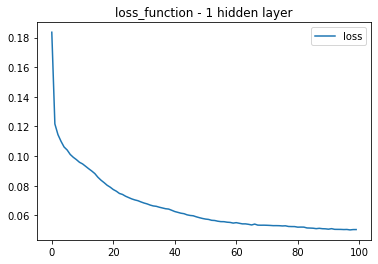

0.949792188533537
0.9332680263650643


In [389]:
# define model - shallow neural net
number_hidden_nodes = 12
number_input_features =5

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_1 = nn.fit(X_train_scaled, y_train_scaled, epochs=100)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))


# Deep Neural Network

In [ ]:
# Define the model - deep neural net
number_input_features = 6
hidden_nodes_layer1 = 18
hidden_nodes_layer2 =9

nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))


nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_1 = nn.fit(X_train_scaled, y_train_scaled, epochs=200)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 2 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))

# 3 hidden layers

In [ ]:
# Define the model - deep neural net
number_input_features = 6
hidden_nodes_layer1 = 18
hidden_nodes_layer2 =9
hidden_nodes_layer3 =4

nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))


nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_1 = nn.fit(X_train_scaled, y_train_scaled, epochs=200)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 3 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))

# The best model for predicting new cases was deep neural network with three hidden layers and 3x neurons. with an r2 value of ~0.95

# Predicting Number of New cases- with NN Model

In [ ]:
# create features(X) and target(y) sets

X = df_new_cases.drop(['new_cases'],axis=1).values

y = df_new_cases['new_cases'].values

y = y.reshape(-1,1)

In [ ]:

# Split dataset into training and testing
# train 95% of data, test 5%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# scale data
X_scaler = StandardScaler()

X_scaler.fit(X_train)

y_scaler= StandardScaler()

y_scaler.fit(y_train)

y_train_scaled=y_scaler.transform(y_train)

y_test_scaled=y_scaler.transform(y_test)

X_train_scaled = X_scaler.transform(X_train)

X_test_scaled = X_scaler.transform(X_test)



In [ ]:
# define model - shallow neural net
number_hidden_nodes = 12
number_input_features = 6

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_1 = nn.fit(X_train_scaled, y_train_scaled, epochs=100)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))


# Deep Neural Network

In [ ]:
# Define the model - deep neural net
number_input_features = 6
hidden_nodes_layer1 = 18
hidden_nodes_layer2 =9

nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))


nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_2 = nn.fit(X_train_scaled, y_train_scaled, epochs=200)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 2 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))

# 3 hidden layers

In [ ]:
# Define the model - deep neural net
number_input_features = 6
hidden_nodes_layer1 = 18
hidden_nodes_layer2 =9
hidden_nodes_layer3 =4

nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))


nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_3 = nn.fit(X_train_scaled, y_train_scaled, epochs=200)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 3 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))

In [ ]:
# Print y_train and y_test predicted[0]
print(y_train_pred)
print(y_test_pred)

In [ ]:
# Convert the scaled predictions to actual values.
print(y_scaler.inverse_transform(y_train_pred))
print(y_scaler.inverse_transform(y_test_pred))